# Visualizing clusters

Step-by-step creation of de-convolved cluster sphere out of its original distribution of stars.

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from astroML.density_estimation import XDGMM
import plotly.graph_objects as go
from plotly.offline import plot

from miscellaneous.error_sampler import ErrorSampler

### Functions

In [15]:
def Jacobi_matrix(ra, dec, w):
       """ Jacobian matrix of the ICRS (not spherical!!) to cartesian transformation """

       a = np.radians(ra)
       d = np.radians(dec)

       J = np.array([
              [(1000 / w) * (- np.sin(a)) *  np.cos(d), (1000 / w) * np.cos(a) *(- np.sin(d)), (- 1000 / w**2) * np.cos(a) * np.cos(d)],
              [(1000 / w) * np.cos(a) * np.cos(d), (1000/w) * np.sin(a) *(- np.sin(d)), (- 1000 / w**2) * np.sin(a) * np.cos(d)],
              [0, (1000/ w) * np.cos(d), (-1000/w **2) * np.sin(d)]

       ])

       return J

def transform_radecplx2xyz(data, cov_radeplx, cols):
       """ Transformation of a single 3x3 covariance matrix in ICRS position coordinates (RA, DEC, plx) into a cartesian covariance matrix, using Jacobian matrices."""

       J = Jacobi_matrix(data[cols[0]], data[cols[1]], data[cols[2]])
       cov_xyz = J @ cov_radeplx @ J.T

       # Calculate the eigenvalues of the covariance matrix
       lambdas, _ = np.linalg.eig(cov_xyz)
       lambda_max = np.max(lambdas)

       return cov_xyz, lambda_max


def build_cartesian_cov_matrix(data, C_radeplx, cols = None):
       """ High-level function that returns the array (C_xyz) made up of individual covariance matrices (cov_xyz). Each covariance matrix in C_xyz corresponds to one star in the input dataset. """

       lambdas = []

       if cols is None:
              cols = ["ra", "dec", "parallax"]

       C_xyz = np.empty(shape=(data.shape[0],3,3))

       for row_idx in range(data.shape[0]):
              star = data.iloc[row_idx]

              single_cov, lambda_max = transform_radecplx2xyz(data = star, cov_radeplx=C_radeplx[row_idx, :, :], cols=cols)

              C_xyz[row_idx, :, : ] = single_cov
              lambdas.append(lambda_max)

       return C_xyz, lambdas

In [16]:
def plot_ellipsoid(mean, cov_matrix, n_points=50):
    # Eigen-decomposition of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Radii are the square roots of the eigenvalues
    radii = np.sqrt(eigenvalues)

    # Parametric angles
    theta = np.linspace(0, np.pi, n_points)  # Polar angle
    phi = np.linspace(0, 2 * np.pi, n_points)  # Azimuthal angle
    theta, phi = np.meshgrid(theta, phi)

    # Parametric equations for the canonical ellipsoid
    x = radii[0] * np.sin(theta) * np.cos(phi)
    y = radii[1] * np.sin(theta) * np.sin(phi)
    z = radii[2] * np.cos(theta)

    # Combine the canonical coordinates into a matrix
    ellipsoid_points = np.array([x.ravel(), y.ravel(), z.ravel()])

    # Apply the rotation using the eigenvectors
    ellipsoid_rotated = eigenvectors @ ellipsoid_points

    # Reshape back to the original shape
    x_rot = ellipsoid_rotated[0, :].reshape(n_points, n_points) + mean[0]
    y_rot = ellipsoid_rotated[1, :].reshape(n_points, n_points) + mean[1]
    z_rot = ellipsoid_rotated[2, :].reshape(n_points, n_points) + mean[2]

    return x_rot, y_rot, z_rot

#### Import clustered dataset

In [17]:
cols = ['source_id', 'ra',
       'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'pm',
       'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr',
       'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr',
       'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
       'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr',
       'astrometric_sigma5d_max', 'ruwe', 'radial_velocity',
       'radial_velocity_error', 'l', 'b', 'fidelity_v2', 'X', 'Y', 'Z',
       'v_a_lsr', 'v_d_lsr', 'U', 'V', 'W',
       'region', 'cluster_label', 'catalog',
       'stability']

In [18]:
df_200 = pd.read_csv("../../Data/Comparison/Full_result_table.csv", usecols=cols)
df_200.loc[:, "catalog"] = "SigMA"
df_clusters = df_200[df_200.cluster_label != -1]  # -1 == field stars

# limit to a test cluster
subset = df_clusters[df_clusters["cluster_label"] == 0]
subset.shape[0]

303

In [19]:
subset["delta_dist"] = 1000 / (subset["parallax"]**2) *subset["parallax_error"]
subset["delta_dist"].mean()
subset["distance"] = 1000 / (subset["parallax"])

/var/folders/z6/y4rdkpdx3vlbwtmngx04x_1w0000gp/T/ipykernel_1931/2426737559.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/z6/y4rdkpdx3vlbwtmngx04x_1w0000gp/T/ipykernel_1931/2426737559.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 1. Calculate Cartesian covariance matrix

In [20]:
sampler_obj = ErrorSampler(data=subset)
sampler_obj.build_covariance_matrix()  # build ICRS covariance matrix
cov_radeplx = sampler_obj.C[:, :3, :3] # position part of the covariance matrix
cov_radeplx.shape

(303, 3, 3)

In [21]:
C_xyz, lambdas = build_cartesian_cov_matrix(data=subset, C_radeplx=cov_radeplx)  # transform into Cartesian coords
print(C_xyz.shape)

(303, 3, 3)


Text(35, 65, 'Mean distance error (plx only)')

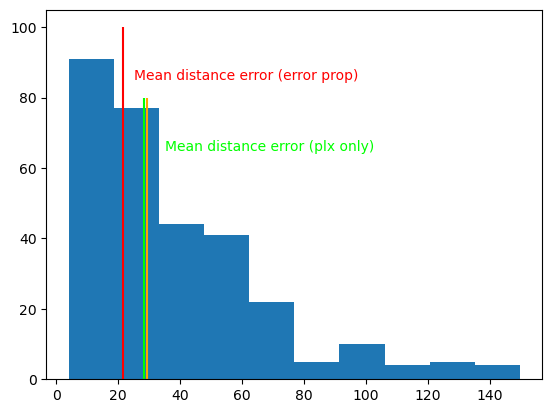

In [22]:
sqrt_lambdas = np.sqrt(lambdas)

import matplotlib.pyplot as plt

plt.hist(sqrt_lambdas)
plt.vlines(x=subset["delta_dist"].mean(),ymin=0,ymax =100, color="red")
plt.vlines(x=subset["distance"].std(),ymin=0,ymax =80, color="lime")

plt.text(x=25, y = 85, s = "Mean distance error (error prop)", color ="red")
plt.text(x=35, y = 65, s = "Mean distance error (plx only)", color ="lime")

## 2. Extreme deconvolution

In [23]:
X = np.vstack([subset.X.to_numpy(),subset.Y.to_numpy(), subset.Z.to_numpy()]).T # bring the stellar coordinates into input shape
Xerr = C_xyz # define the Xerr object for XDGMM as the cartesian covariance matrix

# Fit with n components
n_components = 1
xd = XDGMM(n_components, max_iter=100)
xd.fit(X, Xerr)

# Extract fit parameters
means = xd.mu
covariances = xd.V

## 3. Plotting

In [24]:
f = go.Figure()

# Points
f.add_trace(go.Scatter3d( x=X[:, 0], y=X[:, 1], z=X[:, 2], mode='markers', marker=dict(size=3, color='blue', opacity=0.7),
                          name='Star positions'))

# Gaussian components
for i in range(len(means)):
    mean = means[i]
    cov_matrix = covariances[i]

    # Get the transformed ellipsoid points
    x_rot, y_rot, z_rot = plot_ellipsoid(mean, cov_matrix)

    # Add each ellipsoid to the plot
    f.add_trace(go.Surface(x=x_rot, y=y_rot, z=z_rot, colorscale='Viridis', opacity=0.6))

# Customize layout
f.update_layout(
 scene=dict(
     xaxis_title='X (pc)',
     yaxis_title='Y (pc)',
     zaxis_title='Z (pc)'
 )
)

plot(f)
f.show()

## 4. Put it together for all clusters

In [25]:
# Loop over the clusters
means, covariances = [], []
X_arr = []
for group in np.unique(df_clusters["cluster_label"])[:]:

    # define subset for length check
    subset = df_clusters[df_clusters["cluster_label"] == group]

    sampler_obj = ErrorSampler(data=subset)
    sampler_obj.build_covariance_matrix()  # build ICRS covariance matrix
    cov_radeplx = sampler_obj.C[:, :3, :3] # position part of the covariance matrix
    C_xyz = build_cartesian_cov_matrix(data=subset, C_radeplx=cov_radeplx)  # transform into Cartesian coords

    X = np.vstack([subset.X.to_numpy(),subset.Y.to_numpy(), subset.Z.to_numpy()]).T # bring the stellar coordinates into input shape
    Xerr = C_xyz # define the Xerr object for XDGMM as the cartesian covariance matrix

    # Fit with n components
    n_components = 1
    xd = XDGMM(n_components, max_iter=100)
    xd.fit(X, Xerr)

    # Extract fit parameters
    means.append(xd.mu)
    covariances.append(xd.V)
    X_arr.append(X)

/opt/anaconda3/envs/Sigma_Orion/lib/python3.9/site-packages/astroML/density_estimation/xdeconv.py:75: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



ValueError: could not broadcast input array from shape (303,3,3) into shape (303,)

In [ ]:
len(X_arr)

In [ ]:
f = go.Figure()

for g,X in enumerate(X_arr):

    m = means[g]
    v = covariances[g]
    sub = df_clusters[df_clusters["cluster_label"] == g]

    # Points
    f.add_trace(go.Scatter3d( x=X[:, 0], y=X[:, 1], z=X[:, 2], mode='markers', marker=dict(size=2, opacity=0.7),
                              name=f'Cluster {g}'))

    # Gaussian components
    for i in range(len(m)):
        mean = m[i]
        cov_matrix = v[i]

        # Get the transformed ellipsoid points
        x_rot, y_rot, z_rot = plot_ellipsoid(mean, cov_matrix)

        # Add each ellipsoid to the plot
        f.add_trace(go.Surface(x=x_rot, y=y_rot, z=z_rot, colorscale='Viridis', opacity=0.6, showlegend=False))

# Customize layout
f.update_layout(
 scene=dict(
     xaxis_title='X (pc)',
     yaxis_title='Y (pc)',
     zaxis_title='Z (pc)'
 )
)

plot(f)
f.show()